In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.neighbors import KernelDensity
from scipy.interpolate import CubicSpline
import sqlite3
from datetime import datetime, timedelta
import math
import pandas_datareader as pdr
import yfinance as yf

sns.set()
yf.pdr_override()

In [3]:
input_db_path = os.path.join('C:\\Users\\jinwo\\Documents\\개인 자료\\Backtesting\\Backtest_Python\\Trading', 'OHLCVData.db')

In [4]:
con = sqlite3.connect(input_db_path)
# input : date, expiry, ticker
# date: 거래일, expiry : 만기. expiry > date.
# Limit: expiry only Friday, 한 date로부터 가까운 3개 expiry 정도만
date = '2022-05-13'
expiry = '2022-05-20'

ticker = '^SPX'
SPX_close = pdr.get_data_yahoo('^GSPC', date, date)['Adj Close'][0]
# can be adjusted whenever
fstrikes = np.arange(3500, 5500)

# risk free rate r 
r = 0.03
# time remain to expiry - I used calendar day (business day control is quite tedious)
tau = (datetime.strptime(expiry, '%Y-%m-%d')-datetime.strptime(date, '%Y-%m-%d')).days/365

q_str = 'select date, ticker, expiry, callput, strike, lastPrice, bid, ask, volume, openInterest, impliedVolatility from OptionsData where date = ? and expiry = ? and ticker = ? order by expiry, strike'
options_data = pd.read_sql(q_str, con=con, params=(date, expiry, ticker, ))
con.close()
options_data

,date,ticker,expiry,callput,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility
0,2022-05-13,^SPX,2022-05-20,call,200,3812.45,3768.2,3784.10,1.0,92.0,14.318360
1,2022-05-13,^SPX,2022-05-20,put,200,0.05,0.0,0.05,1.0,103.0,5.562503
2,2022-05-13,^SPX,2022-05-20,call,400,3612.55,3572.9,3576.30,1.0,3.0,10.237308
3,2022-05-13,^SPX,2022-05-20,put,400,0.05,0.0,0.00,4.0,33.0,0.500005
4,2022-05-13,^SPX,2022-05-20,call,600,3492.20,0.0,0.00,NaN,1.0,0.000010
...,...,...,...,...,...,...,...,...,...,...,...
780,2022-05-13,^SPX,2022-05-20,put,7400,2967.39,0.0,0.00,7.0,8.0,0.000010
781,2022-05-13,^SPX,2022-05-20,put,7500,3075.00,0.0,0.00,2.0,3.0,0.000010
782,2022-05-13,^SPX,2022-05-20,call,7500,0.10,0.0,0.00,NaN,7.0,0.500005
783,2022-05-13,^SPX,2022-05-20,call,7600,0.30,0.0,0.00,NaN,1.0,0.500005


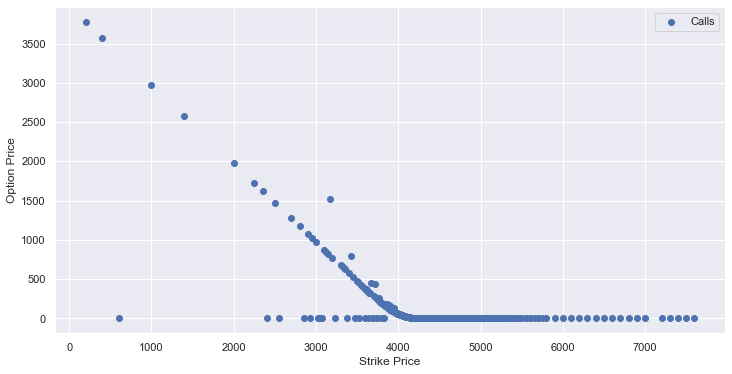

In [5]:
# bid ask mid
options_data['bid_ask_mid'] = (options_data['bid'] + options_data['ask']) / 2
options_data = options_data.fillna(0)

figure = plt.figure(figsize=(12,6))
call_data = options_data.loc[options_data['callput']=='call']

plt.scatter(call_data['strike'], call_data['bid_ask_mid'], label='Calls')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

In [6]:
call_data

,date,ticker,expiry,callput,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,bid_ask_mid
0,2022-05-13,^SPX,2022-05-20,call,200,3812.45,3768.2,3784.1,1.0,92.0,14.318360,3776.15
2,2022-05-13,^SPX,2022-05-20,call,400,3612.55,3572.9,3576.3,1.0,3.0,10.237308,3574.60
4,2022-05-13,^SPX,2022-05-20,call,600,3492.20,0.0,0.0,0.0,1.0,0.000010,0.00
7,2022-05-13,^SPX,2022-05-20,call,1000,3217.29,2974.9,2977.7,150.0,151.0,6.075503,2976.30
12,2022-05-13,^SPX,2022-05-20,call,1400,2890.52,2568.4,2584.3,0.0,0.0,4.670140,2576.35
...,...,...,...,...,...,...,...,...,...,...,...,...
775,2022-05-13,^SPX,2022-05-20,call,7200,0.05,0.0,0.0,0.0,72.0,0.500005,0.00
777,2022-05-13,^SPX,2022-05-20,call,7300,0.05,0.0,0.1,60.0,60.0,1.187504,0.05
779,2022-05-13,^SPX,2022-05-20,call,7400,0.10,0.0,0.0,10.0,24.0,0.500005,0.00
782,2022-05-13,^SPX,2022-05-20,call,7500,0.10,0.0,0.0,0.0,7.0,0.500005,0.00


In [7]:
cubic_spx_call = CubicSpline(call_data['strike'], call_data['bid_ask_mid'])

In [8]:
def calc_pdf_price(strikes, o_price, tau, r):
    # ac/ak
    o_price_prime = np.gradient(o_price, strikes)
    # a2c/ak2
    o_price_pprime = np.gradient(o_price_prime, strikes)
    
    # f(K) = e^rt * a2c/ak2
    return np.exp(tau*r)*o_price_pprime

In [9]:
from scipy.ndimage import gaussian_filter1d

pdf_raw_call = calc_pdf_price(fstrikes, cubic_spx_call(fstrikes), tau, r)
pdf_raw_call = pd.Series(pdf_raw_call)
pdf_gaussian_call = pdf_raw_call
pdf_gaussian_call.loc[pdf_gaussian_call < 0] = 0
pdf_gaussian_call = gaussian_filter1d(pdf_raw_call, 5)

In [10]:
# samples
samples_call = []

for i in range(len(fstrikes)):
    n = int(pdf_gaussian_call[i]*10000)
    curr_c = [fstrikes[i]]*n
    samples_call.extend(curr_c)

strikes_call = call_data['strike']

In [11]:
from scipy.stats import norm

# C = SN(d1) - N(d2)Ke^-rt
def call_val(S, K, sigma, tau=0, r=0):
    # avoid divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)
        d2 = d1 - sigma * np.sqrt(tau)

    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * tau))

# v = ac/asigma = SN'(d1) * sqrt(t) = ap/asigma
def vega(S, K, sigma, tau=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)
    
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(tau)

# Implied Volatility
def bs_iv_call(price, S, K, tau=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_val(S, K, iv, tau, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = vega(S, K, iv, tau, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))

# probability
temp_c = scipy.stats.gaussian_kde(samples_call).pdf(strikes_call)

color = 'tab:red'
ax1.set_xlabel('SPX Price (or Strike)')
ax1.set_ylabel('Probability', color=color)
ax1.plot(strikes_call, temp_c, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.text(0.9, 0.9, 'Max Probability at : '+str(call_data.iloc[np.argmax(temp_c), :]['strike']), 
         horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

plt.title('SPX Implied Probability for expiry '+expiry+' on '+date)
fig.tight_layout()

plt.savefig('SPX expiry '+expiry+' on '+date+'.png')

plt.show()